# Fifth order Monte Carlo

We will always assume that $\bar{n}=1$ for all states. We also assume that there is no displacement in the system, that is, $\bar{\zeta}=0$.

For squeezed states, $\bar{m}=\sqrt{\bar{n}(\bar{n}+1)}=\sqrt{2}$

For squashed states, $\bar{m} = \bar{n}= 1$

For lossy squeezed states, $\eta=\tfrac{1}{2}$, $\bar{n}=2$. Which becomes $\bar{n}^{\prime}=\eta\bar{n}=1$ and $\bar{m}^{\prime}=\eta\sqrt{\bar{n}(\bar{n}+1)}=\sqrt{\tfrac{3}{2}}$

For thermal states, $\bar{m} = 0$

Also,
$N_{out} = U^*N_{in}U^T$ and $M_{out} = UM_{in}U^T$

In [6]:
from symbolic_cumulants import montrealer_numba
from scipy.stats import unitary_group
from numpy import identity, zeros, empty, absolute
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [4]:
def mc_cumulant(n, m, l, trials):
    assert len(n)==len(m), 'n and m should have the same size'
    assert l >= 4, 'l should be at least equal to the order of the cumulant.'
    size = len(n)
    mc_order1 = zeros((3,l+1,size), np.float64)
    mc_order2 = zeros((3,l+1,size), np.float64)
    mc_order3 = zeros((3,l+1,size), np.float64)

    for i in range(trials): #loop on the trials
        U = unitary_group.rvs(l)
        UT = U.T #to transpose only once
        UC = U.conj() #to conjugate only once
        mc_trial = empty((1,l+1,size), np.float64) #Size decreased from 3 to 1
        mc_trial[:,0] = 0 #cumulant is 0 for K=0

        order = 5

        for k in range(1, l+1): #loop on the modes
            N = UC[:order,:k] @ UT[:k,:order]
            M = U[:order,:k] @ UT[:k,:order]

            for p, q, r in zip(n,m, range(size)): #loop on the light states
                    NN = p*N
                    MM = q*M
                    A = np.block([[MM.conj(), NN],[ NN.conj(), MM]])
                    mc_trial[0,k,r] = montrealer_numba(A).real #real only
        
        mc_order1 += mc_trial
        mc_order2 += mc_trial**2
        mc_order3 += mc_trial**3

    mc_mean = mc_order1/trials
    mc_std = np.sqrt(mc_order2/trials-mc_mean**2)
    mc_skewness = (mc_order3-3*mc_mean*mc_std**2-mc_mean**3)
    return mc_mean, mc_std, mc_skewness

### Data export

In [5]:
n = [1,1,1,1]
m = [np.sqrt(2), np.sqrt(3/2), 1, 0]
l = 100
trials = int(1e3)
today = '0211'

data_cumulants = mc_cumulant(n, m, l, trials)

name1 = ['mean', 'std', 'skewness']
name2 = ['second', 'third', 'fourth']

#ADD DATA EXPORT PART

### Time scaling test

To have an idea of the required time to simulate 10 million matrices.

46.55338814597071


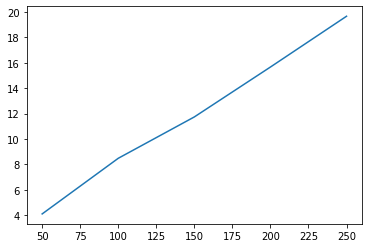

In [11]:
n = [1,1,1,1]
m = [np.sqrt(2), np.sqrt(3/2), 1, 0]
trials = [50, 100, 150, 200, 250]
timer = []
for i in trials:
    toc = time()
    data_cumulants = mc_cumulant(n, m, l, i)
    tic = time()
    timer.append(tic-toc)

plt.plot(trials, timer)

estime_10_million = sum([timer[i]/trials[i] for i in range(5)])*1e7
print(estime_10_million/60/60/24) #number of days of simulation

### Plot

Text(0.5, -0.02, 'Number of non-vacuum modes')

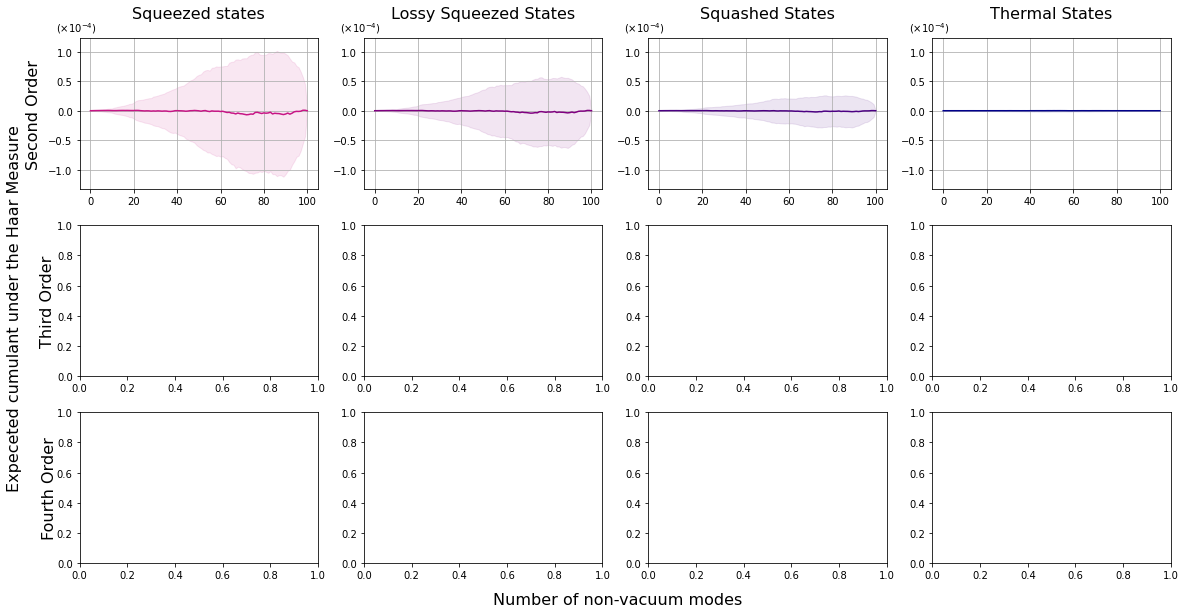

In [7]:
from math import log10, floor

def find_exp(number) -> int:
    base10 = log10(abs(number))
    return floor(base10)

colors = ['mediumvioletred', 'purple', 'indigo', 'darkblue']
orders = ['Fifth']
states = ['Squeezed states', 'Lossy Squeezed States', 'Squashed States', 'Thermal States']

k = list(range(l+1))
fig, axs = plt.subplots(3, 4, figsize=(16, 8)) #order by states
fig.tight_layout(pad=1.5)

for i, order in enumerate(orders):
    mean_minus_std = data_cumulants[0][i]-data_cumulants[1][i]
    mean_plus_std = data_cumulants[0][i]+data_cumulants[1][i]
    vmin = np.min(mean_minus_std)
    vmax = np.max(mean_plus_std)
    exponant = find_exp(vmax)
    factor = 10**-exponant
    gap = (vmax-vmin)*factor
    
    for j, state in enumerate(states):
        axs[i,j].set_ylim([vmin*factor-gap*.1, vmax*factor+gap*.1])
        axs[i,j].grid()
        axs[i,j].plot(k, data_cumulants[0][i,:,j]*factor, '-', c=colors[j], rasterized=True)
        axs[i,j].fill_between(k, (mean_minus_std[:,j])*factor, (mean_plus_std[:,j])*factor, alpha=0.1, color=colors[j])
        axs[i,j].text(-0.1, 1.12, r'$\left(\times 10^{0}\right)$'.format({exponant}),
            fontsize=10, 
            horizontalalignment='left',
            verticalalignment='top',
            transform=axs[i,j].transAxes)

axs[0,0].set_title('Squeezed states', pad=20, fontsize=16, fontweight=540)
axs[0,1].set_title('Lossy Squeezed States', pad=20, fontsize=16, fontweight=540)
axs[0,2].set_title('Squashed States', pad=20, fontsize=16, fontweight=540)
axs[0,3].set_title('Thermal States', pad=20, fontsize=16, fontweight=540)

axs[0,0].set_ylabel('Second Order', fontsize=16, labelpad=7)
axs[1,0].set_ylabel('Third Order', fontsize=16, labelpad=2)
axs[2,0].set_ylabel('Fourth Order', fontsize=16, labelpad=0)
fig.supylabel('Expeceted cumulant under the Haar Measure', fontsize=16, fontweight=540, x=-0.03)
fig.supxlabel('Number of non-vacuum modes', fontsize=16, fontweight=540, y=-0.02)

#plt.savefig('data/haar_cumulant_std_0211.pdf', bbox_inches='tight')